In [1]:
import numpy as np
import PyDSTool as dst
from PyDSTool.Toolbox import phaseplane as pp
from scipy.optimize import fsolve

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import display, Math

In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [4]:
mpl.rcParams['figure.figsize'] = [6, 4]
mpl.rcParams['font.size'] = 16
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 8

In [5]:
figdir = './figures/'
plt.rc('text', usetex=True)

# Carryover of a saddle-node bifurcation
# Application: gen activation model

The gen activation model is
$$
    \dot x = s - rx + \frac{x^{2}}{1+x^{2}},
$$
where
where $r>0$ is the degradation rate and $s\geq0$ is the activating signal (add references here in markdown syntax: Strogatz1994, Lewis1977).


## 1. Phase plane analysis

Steady states are given by
$$
\dot x = 0 \implies rx - s = \frac{x^2}{1+x^2}
$$

In [6]:
def f(x, s, r):
    return s - r*x + x**2/(1 + x**2)

def fprime(x, s, r):
    return -r + 2*x/(1 + x**2)**2

def plot_phaseplot(s, r, file=False):
    # baseline
    xx = np.arange(0, 3, 0.01)
    plt.hlines(0, min(xx), max(xx), 'r')
    # arrows
    xx = np.arange(0, 3, 0.2)
    for x in xx:
        if f(x, s, r) < 0:
            plt.plot(x, 0, '<g')
        elif f(x, s, r) > 0:
            plt.plot(x, 0, '>g')
    # phase portrait
    xx = np.arange(0, 3, 0.01)
    yy = f(xx, s, r)
    plt.plot(xx, yy, 'b')
    # steady states
    xx = np.arange(0, 3, 0.1)
    for x in xx:
        ss = fsolve(f, x, (s, r), full_output=True)
        if ss[2] == 1:
            if fprime(ss[0], s, r) < 0:
                plt.plot(ss[0], 0, 'ob', ms=10)
            else:
                plt.plot(ss[0], 0, 'ob', ms=10, markerfacecolor='white')
    # plot specs
    plt.xlabel('$x$')
    plt.xlim((0., 2.5))
    plt.ylabel('$\dot x$')
    plt.ylim((-0.20, 0.20))
    if file:
        plt.savefig(file, bbox_inches='tight')
    plt.show()

In [7]:
interact(plot_phaseplot, 
         s=widgets.FloatSlider(min=0, max=0.2, step=0.01, value=0.),
         r=widgets.FloatSlider(min=0, max=0.8, step=0.01, value=0.4),
         file=fixed(False));

interactive(children=(FloatSlider(value=0.0, description='s', max=0.2, step=0.01), FloatSlider(value=0.4, desc…

Assuming the activating signal $s$ is zero and the activity of the is null, the gen, remains inactive.

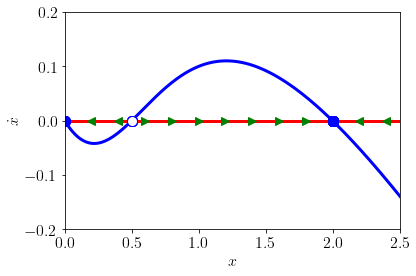

In [8]:
plot_phaseplot(0.0, 0.4)

But if the activating signal increases above a threshold value $s^*$, the gene becomes active in via a critical transition and remains active even after the activating signal returns to zero.

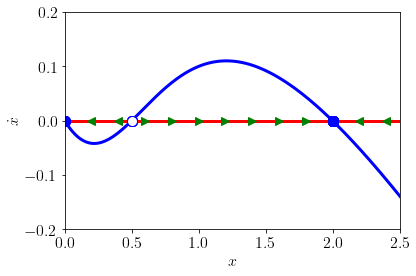

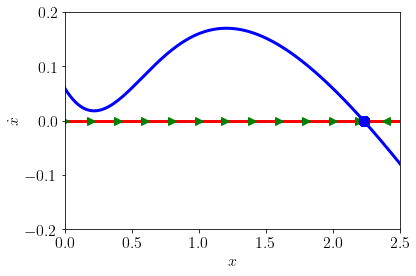

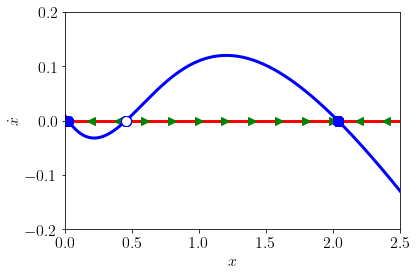

In [9]:
plot_phaseplot(0., 0.4, figdir + 'ApplicationGenPhasePortrait1.pdf')
plot_phaseplot(0.06, 0.4, figdir + 'ApplicationGenPhasePortrait2.pdf')
plot_phaseplot(0.01, 0.4)

## 2. Bifurcation diagram

We can construct the bifurcation diagram using continuation and the `PyDSTool` library of python.

In [24]:
# dynamical system
xstr = 's-r*x+x**2/(1+x**2)'
params = {'s': 0, 'r':0.4}
ics = {'x': 2.0}
DSargs = dst.args(name='GenActivation')
DSargs.pars = params
DSargs.tdata = [0, 2]
DSargs.pdomain = {'s': [0, 0.2], 'r': [0, 1.]}
DSargs.xdomain = {'x': [0, 10.0]}
DSargs.varspecs = {'x': xstr}
DSargs.ics = ics
DS = dst.Generator.Vode_ODEsystem(DSargs)

In [25]:
fps = pp.find_fixedpoints(DS, n=4, eps=1e-8)
fps

({'x': array([0.])}, {'x': array([2.])})

In [26]:
# bifurcation diagram for s
# first branch
PC = dst.ContClass(DS)
name1 = 'EQ1'
PCargs = dst.args(name=name1)
PCargs.type = 'EP-C'
PCargs.initpoint = {'x': 0.0}
PCargs.freepars = ['s']
PCargs.StepSize = 1e-3
PCargs.MaxNumPoints = 800
PCargs.MaxStepSize = 5e-2
PCargs.MinStepSize = 1e-6
PCargs.MaxTestIters = 20
PCargs.LocBifPoints = 'all'
PCargs.SaveEigen = True
PCargs.StopAtPoints = ['B']
PCargs.verbosity = 0

PC.newCurve(PCargs)
# PC.curves[name1].backward()
PC.curves[name1].forward()

# second branch
name2 = 'EQ2'
PCargs = dst.args(name=name2)
PCargs.type = 'EP-C'
PCargs.initpoint = {'x': 2.0, 's': 0.0}
PCargs.freepars = ['s']
PCargs.StepSize = 1e-3
PCargs.MaxNumPoints = 800
PCargs.MaxStepSize = 5e-2
PCargs.MinStepSize = 1e-6
PCargs.MaxTestIters = 20
PCargs.LocBifPoints = 'all'
PCargs.SaveEigen = True
PCargs.StopAtPoints = ['B']
PCargs.verbosity = 0

PC.newCurve(PCargs)
# PC.curves[name2].backward()
PC.curves[name2].forward()

Indeed there is a bifurcation point (`LP1`) at which a critical transition drives gen activation.

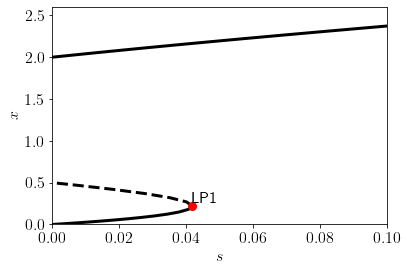

In [27]:
PC['EQ1'].display(('s', 'x'), stability=True, linewidth=3)
PC['EQ2'].display(('s', 'x'), stability=True, linewidth=3)
PC.plot.fig1.toggleAll('off', bytype=['P','B'])
PC.plot.fig1.axes1.axes.set_xlabel('$s$', fontsize=16)
PC.plot.fig1.axes1.axes.set_xlim((0.0, 0.10))
PC.plot.fig1.axes1.axes.set_ylabel('$x$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylim((0.0, 2.6))
PC.plot.fig1.axes1.axes.set_title('')
plt.savefig(figdir + 'ApplicationGenOriginalBifurcation.pdf', bbox_inches='tight')
plt.show()

The actual value of $s$ is

In [14]:
PC['EQ1'].getSpecialPoint('LP1')['s']

0.041834447154491076

From here we can follow the bifurcation point varying both parameters $s$ and $r$.

In [15]:
# Two-parameter bifurcation
namefold1 = 'F01'
PCargs = dst.args(name=namefold1)
PCargs.type = 'LP-C'
PCargs.initpoint = 'EQ1:LP1'
PCargs.freepars = ['s', 'r']
PCargs.StepSize = 1e-2
PCargs.MaxNumPoints = 200
PCargs.MaxStepSize = 5e-2
PCargs.MinStepSize = 1e-4
PCargs.SaveEigen = True
PCargs.SaveJacobian = True
PCargs.LocBifPoints = 'all'
PCargs.StopAtPoints = ['B']
PCargs.verbosity = 0
PC.newCurve(PCargs)
PC.curves[namefold1].forward()
PC.curves[namefold1].backward()

/home/shigoto/.local/lib/python3.8/site-packages/PyDSTool/PyCont/TestFunc.py:366: LinAlgWarning: Diagonal number 1 is exactly zero. Singular matrix.
  MLU = linalg.lu_factor(c_[r_[A,transpose(self.data.C)], r_[self.data.B,self.data.D]])


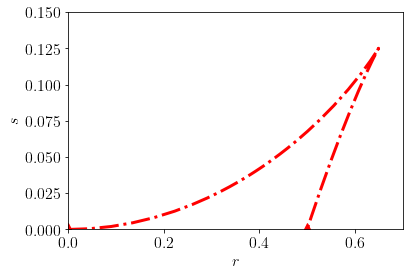

In [16]:
PC[namefold1].display(('r', 's'), stability=True, linewidth=3)
PC.plot.toggleLabels('off')
PC.plot.fig1.toggleAll('off', bytype=['P', 'BT', 'CP'])
PC.plot.fig1.axes1.axes.set_xlim((0.0, 0.7))
PC.plot.fig1.axes1.axes.set_xlabel('$r$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylim((0.0, 0.15))
PC.plot.fig1.axes1.axes.set_ylabel('$s$', fontsize=16)
PC.plot.fig1.axes1.axes.set_title('')
# plt.savefig(dir + 'ApplicationGenTwoParBifurcation.pdf', bbox_inches='tight')
plt.show()

The enclosed region corresponds to the region with 3 steady states.

In [17]:
PC['F01'].getSpecialPoint('CP1')

r:  0.6495190528170736
s:  0.12499999998772815
x:  0.5773502612833525
Labels: LP ({'data': args (
 V = {'x': 0.9999999999999997, 's': 1.3291955507230837e-08, 'r': 2.304637961980731e-08},
 ds = 0.05,
 evals = [0.+0.j],
 evecs = [[1.]],
 jacx = [[0.]],
 jacp = [[ 1.         -0.57735026]]
), 'domain': 'inside', 'stab': 'N'})
Labels: CP ({'data': args (
 X = {'x': 0.5773502612833525, 's': 0.12499999998772815, 'r': 0.6495190528170736},
 V = {'x': 0.9999999999999997, 's': 1.3291955507230837e-08, 'r': 2.304637961980731e-08},
 eigs = [0.+0.j]
), 'plot': No args defined, 'name': 'CP1'})

## 3. Turn $s$ into a variable

Suppose that we turn $s$ into a variable to get the system
$$
\begin{aligned}
    \dot x &= s - rx + \frac{x^{2}}{1+x^{2}}, \\
    \dot s &= a - bs.
\end{aligned}
$$

According to the carryover theory, saddle-node bifurcation in the extended system would be a the intersection between the two-parameter bifurcation curve and the nullclines of $\dot s$ ($s=c=\frac{a}{b}$ in this case).

Consider $c=0.6$.

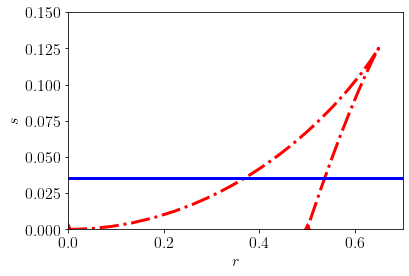

In [18]:
PC[namefold1].display(('r', 's'), stability=True, linewidth=3)
PC.plot.toggleLabels('off')
PC.plot.fig1.toggleAll('off', bytype=['P','BT','CP'])
PC.plot.fig1.axes1.axes.set_xlim((0.0, 0.7))
PC.plot.fig1.axes1.axes.set_xlabel('$r$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylim((0.0, 0.15))
PC.plot.fig1.axes1.axes.set_ylabel('$s$', fontsize=16)
PC.plot.fig1.axes1.axes.set_title('')
plt.axhline(y=6/169, lw=3, color='b')
plt.savefig(figdir + 'ApplicationGenTwoParBifurcation2.pdf', bbox_inches='tight')
plt.show()

In [19]:
# dynamical system
xstr = 's-r*x+x**2/(1+x**2)'
sstr = 'a-b*s'
params = {'r': 125/338, 'a': 6/169, 'b': 1}
ics = {'x': 1, 's': 0}
DSargs = dst.args(name='GenActivation')
DSargs.pars = params
DSargs.tdata = [0, 2]
DSargs.pdomain = {'r': [0, 0.8]}
DSargs.xdomain = {'x': [0, 10.0], 's': [0, 0.2]}
DSargs.varspecs = {'x': xstr, 's': sstr}
DSargs.ics = ics
DS = dst.Generator.Vode_ODEsystem(DSargs)

In [20]:
fps = pp.find_fixedpoints(DS, n=4, eps=1e-8)
fps

({'s': 0.03550295857988166, 'x': 0.1999999971740397},
 {'s': 0.03550295857988166, 'x': 2.4})

In [21]:
PC = dst.ContClass(DS)
name1 = 'EQ1'
PCargs = dst.args(name=name1)
PCargs.type = 'EP-C'
PCargs.initpoint = {'x': 0, 's': 6/169}
PCargs.freepars = ['r']
PCargs.StepSize = 1e-3
PCargs.MaxNumPoints = 800
PCargs.MaxStepSize = 5e-2
PCargs.MinStepSize = 1e-6
PCargs.MaxTestIters = 40
PCargs.LocBifPoints = 'all'
PCargs.SaveEigen = True
PCargs.StopAtPoints = ['B']
PCargs.verbosity = 2

PC.newCurve(PCargs)
PC.curves[name1].backward()
PC.curves[name1].forward()


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000000
  |transpose(A)p| = 0.000000

LP Point found 
0 : 
s  =  0.03550295857988166
x  =  0.20000020347230507
r  =  0.3698224852072626

Eigenvalues = 

     (0.000000,0.000000)
     (-1.000000,0.000000)


a = 0.7823163948814567


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000000
  |transpose(A)p| = 0.000000

LP Point found 
0 : 
s  =  0.03550295857988166
x  =  0.925820322394435
r  =  0.536866093359218

Eigenvalues = 

     (-0.000000,0.000000)
     (-1.000000,0.000000)


a = 0.24533457686446805

B Point found 
0 : 
s  =  0.03550295857988166
x  =  10.00000000637913
r  =  0.10256019678391338

B Point found 
0 : 
s  =  0.03550295857988166
x  =  0.04715162468390597
r  =  0.8000000541524838



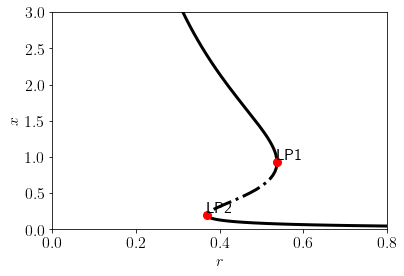

In [22]:
PC['EQ1'].display(('r', 'x'), stability=True, linewidth=3)
PC.plot.fig1.toggleAll('off', bytype=['P','B'])
PC.plot.fig1.axes1.axes.set_xlim((0, 0.8))
PC.plot.fig1.axes1.axes.set_xlabel('$r$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylim((0, 3.0))
PC.plot.fig1.axes1.axes.set_ylabel('$x$', fontsize=16)
PC.plot.fig1.axes1.axes.set_title('')
plt.savefig(figdir + 'ApplicationGenExtended2Bifurcation.pdf', bbox_inches='tight')
plt.show()